Here, we following James' approach of testing the strategy. In this notebook, we are going to test the "improve pavement" strategy. 

Tl, Dr: This strategy doesn't show any effectiveness. 

We first load the necessary packages

In [37]:
import pandas as pd
#import folium
from folium.plugins import MarkerCluster
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
#import tabulate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import pymc as pm
import arviz as az
import pytensor
import warnings
from sklearn.exceptions import UndefinedMetricWarning
pytensor.config.cxx = ""
from catboost import Pool

In [ ]:
# Load the data
df = pd.read_csv("rural I-40 Madison and Henderson crashes.csv")
#df = pd.read_csv("../datasets/rural I-40 Madison and Henderson crashes.csv")


# Drop rows missing geolocation or crash type (Clean the data)
df = df[df["Longitude"].notnull() & df["Latitude"].notnull() & df["Crash Type"].notnull()]



In [54]:
df['Longitude Segment'] = pd.cut(df['Longitude'], bins=20)
# Define injurious crashes
df["Injurious"] = df["Crash Type"].str.lower().apply(
    lambda x: 1 if "injury" in x or "fatal" in x or "serious injury" in x else 0
)

# Remove unwanted string values
df = df[
    ~df['Pavement condition'].isin(["none", "MC"])]



# Convert to numeric (if not already)
df['Pavement condition'] = pd.to_numeric(df['Pavement condition'])


# Now safely create your mask
targetable_mask = (df['Pavement condition'] <= 2)


# Group by longitude segment
summary = (
    df.groupby('Longitude Segment')
    .agg(
        Total_Crashes=('Crash Type', 'count'),
        Injurious_Crashes=('Injurious', 'sum'),
        Targetable_Crashes=('Crash Type', lambda x: targetable_mask.loc[x.index].sum())
    )
    .reset_index()
)

# Compute injury rate
summary["Injury Rate"] = (summary["Injurious_Crashes"] / summary["Total_Crashes"]).round(2)

# Filter segments with at least one targetable crash
summary = summary[summary["Targetable_Crashes"] > 0]

# Sort by injury rate (descending)
summary_sorted = summary.sort_values(by="Injury Rate", ascending=False)

# Display
print(summary_sorted[["Longitude Segment", "Total_Crashes", "Targetable_Crashes", "Injurious_Crashes", "Injury Rate"]])



     Longitude Segment  Total_Crashes  Targetable_Crashes  Injurious_Crashes  \
9   (-88.678, -88.634]             42                  42                 15   
19  (-88.242, -88.199]             31                  31                 11   
10  (-88.634, -88.591]             56                  56                 17   
8   (-88.722, -88.678]             28                  15                  8   
18  (-88.286, -88.242]             32                  13                  7   
11  (-88.591, -88.547]             41                  35                  6   

    Injury Rate  
9          0.36  
19         0.35  
10         0.30  
8          0.29  
18         0.22  
11         0.15  


/var/folders/38/vj2ynxq51tx1g3vphmrk2cvr0000gn/T/ipykernel_76748/1131397668.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Longitude Segment')


In [55]:
# Create Segment mask. We use this to choose the segment. In this case, we use segment 9 because it has the highest injury rate
segment_mask = (df["Longitude"] > -88.678) & (df["Longitude"] <= -88.634)

# Split the dataset
holdout_segment = df[segment_mask].copy()
training_data = df[~segment_mask].copy()
print(f"Training data shape: {training_data.shape}")
print(f"Holdout Segment 7 shape: {holdout_segment.shape}")

Training data shape: (746, 19)
Holdout Segment 7 shape: (53, 19)


In [56]:
# Feature list for prediction
geo_features = [
    'Presence of guardrails',
    'Cable barriers',
    'Rumble strips',
    'Pavement condition',
    'Proximity to highway entrances and exits',
    'Urban vs. rural environment',
    'Surrounding natural features',
    'Shoulder type and width',
    'Posted speed limit',
    'Presence and type of median or divider',
    'Lane markings and signage visibility',
    'Nighttime lighting and visibility'
]

# Separate features and target
X = training_data[geo_features].copy()
y = training_data["Injurious"]

# Split into training and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# 1. Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# 2. Apply to training split
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 3. Print class balance before and after
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({0: 415, 1: 107})
Resampled class distribution: Counter({0: 415, 1: 415})


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.51      0.63       178
           1       0.24      0.59      0.34        46

    accuracy                           0.53       224
   macro avg       0.53      0.55      0.48       224
weighted avg       0.71      0.53      0.57       224

Confusion Matrix:
 [[91 87]
 [19 27]]


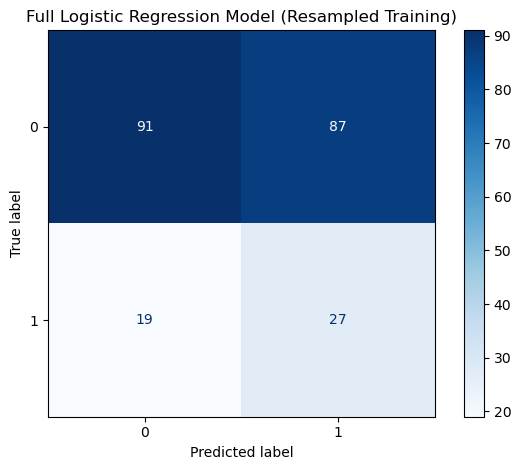

In [57]:
# 1. Preprocessing: One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), geo_features)
    ]
)

# 2. Logistic regression pipeline
logreg2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 3. Fit model
logreg2.fit(X_train_resampled, y_train_resampled)

# 4. Predict and evaluate
y_pred = logreg2.predict(X_val)

print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# 5. Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
disp.ax_.set_title("Full Logistic Regression Model (Resampled Training)")
plt.tight_layout()
plt.show()

Best threshold for F1: 0.390
Precision: 0.25, Recall: 0.83, F1: 0.38


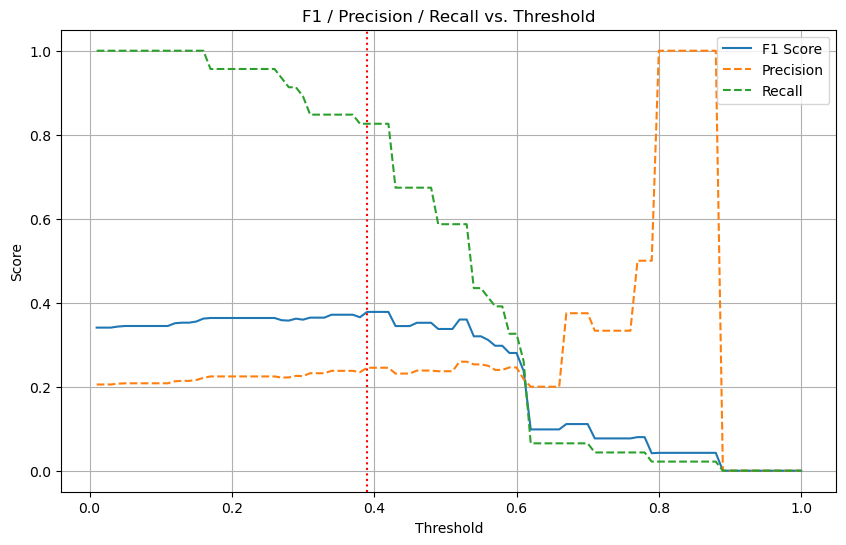

In [58]:
# get probabilities
y_probs = logreg2.predict_proba(X_val)[:, 1]

# Simulate thresholds from 0.01 to 1.0
thresholds = np.linspace(0.01, 1.0, 100)
f1_scores = []
precisions = []
recalls = []

# Compute F1, precision, and recall at each threshold
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best threshold for F1: {best_threshold:.3f}")
print(f"Precision: {precisions[best_index]:.2f}, Recall: {recalls[best_index]:.2f}, F1: {best_f1:.2f}")

# Optional: plot the scores
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.axvline(x=best_threshold, color='red', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 / Precision / Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Identify categorical columns by name

cat_indices =  geo_features


# Step 2: Initialize CatBoost
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    cat_features=cat_indices
)

# Step 3: Define grid search parameters
param_grid = {
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 3, 5]
}

# Step 4: GridSearchCV
grid = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Step 5: Fit on resampled training data
grid.fit(X_train_resampled, y_train_resampled)

# Best estimator becomes our final Catmodel
Catmodel = grid.best_estimator_

# Step 6: Predict on validation set
y_pred_val = Catmodel.predict(X_val)

# Step 7: Evaluation
print("Best Parameters:", grid.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

Confusion Matrix:
 [[ 59 119]
 [  8  38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.33      0.48       178
           1       0.24      0.83      0.37        46

    accuracy                           0.43       224
   macro avg       0.56      0.58      0.43       224
weighted avg       0.75      0.43      0.46       224



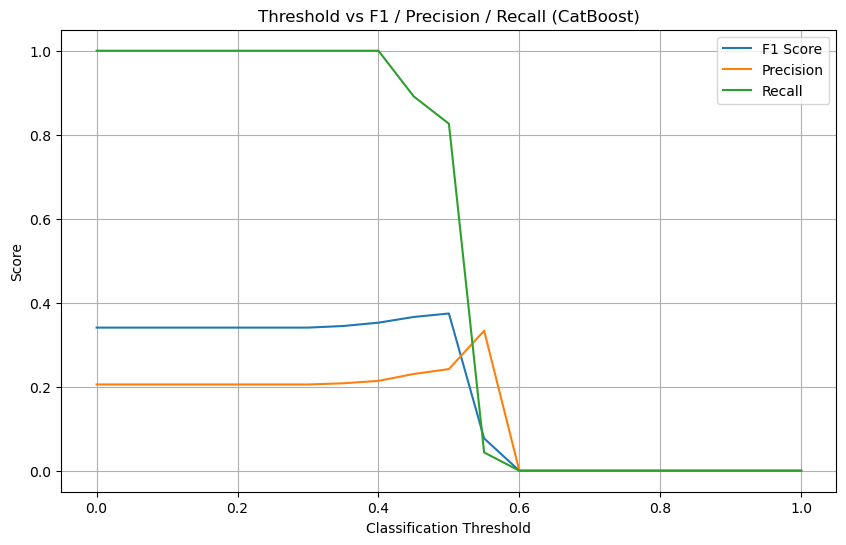

Best F1 threshold: 0.50
Precision: 0.24, Recall: 0.83, F1: 0.37


In [60]:
# Predict probabilities for the positive class (injurious)
y_probs = Catmodel.predict_proba(X_val)[:, 1]

# Range of thresholds to try
thresholds = np.arange(0.0, 1.05, 0.05)

f1_scores = []
precisions = []
recalls = []

# Silence precision warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Evaluate metrics for each threshold
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.title("Threshold vs F1 / Precision / Recall (CatBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Print best threshold
best_thresh_idx = np.argmax(f1_scores)
print(f"Best F1 threshold: {thresholds[best_thresh_idx]:.2f}")
print(f"Precision: {precisions[best_thresh_idx]:.2f}, Recall: {recalls[best_thresh_idx]:.2f}, F1: {f1_scores[best_thresh_idx]:.2f}")


In [61]:
# Create X_before using only geo_features
X_before = holdout_segment[geo_features].copy()
X_after = X_before.copy()

# Apply the intervention
X_after['Pavement condition'] = '4'  # categorical feature (string)


# --- Logistic Regression (logreg2) ---
logreg_pred_before = logreg2.predict(X_before)
logreg_pred_after = logreg2.predict(X_after)
print("\n--- Logistic Regression ---")
print(f"Before Intervention Injurious Predictions: {logreg_pred_before.sum()}")
print(f"After Intervention Injurious Predictions:  {logreg_pred_after.sum()}")

# --- CatBoost (Catmodel) ---
cat_features = geo_features.copy()

# Subset and re-order both X_before and X_after to match training input
X_before = holdout_segment[geo_features].copy()
X_after = holdout_segment[geo_features].copy()

# Apply intervention
X_after['Pavement condition'] = '4'

# Convert ALL categorical features to string
for col in cat_features:
    X_before[col] = X_before[col].astype(str)
    X_after[col] = X_after[col].astype(str)

# Build CatBoost Pools
pool_before = Pool(X_before, cat_features=cat_features)
pool_after = Pool(X_after, cat_features=cat_features)

# Run predictions
cat_pred_before = Catmodel.predict(pool_before)
cat_pred_after = Catmodel.predict(pool_after)
print("\n--- CatBoost ---")
print(f"Before Intervention Injurious Predictions: {cat_pred_before.sum()}")
print(f"After Intervention Injurious Predictions:  {cat_pred_after.sum()}")



--- Logistic Regression ---
Before Intervention Injurious Predictions: 31
After Intervention Injurious Predictions:  31

--- CatBoost ---
Before Intervention Injurious Predictions: 53
After Intervention Injurious Predictions:  53


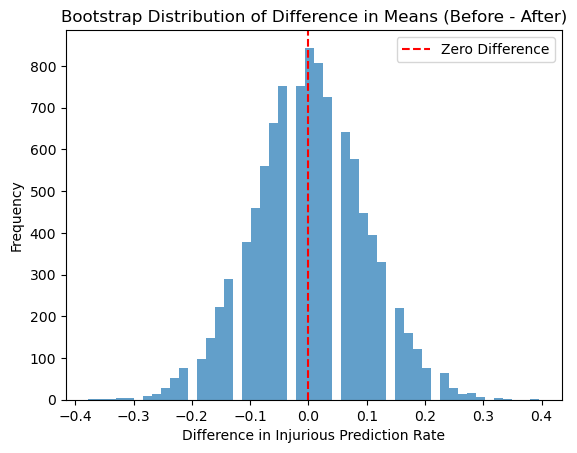

Logistic Regression:
Mean Before = 0.585 (95% CI: 0.453 – 0.717)
Mean After  = 0.585 (95% CI: 0.453 – 0.717)
p-value     = 0.5362



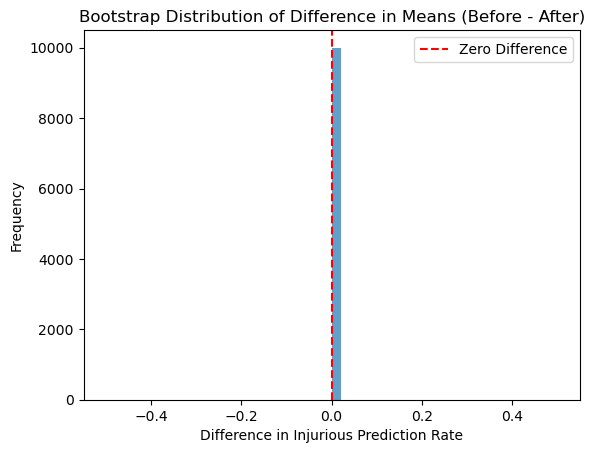

CatBoost:
Mean Before = 1.000 (95% CI: 1.000 – 1.000)
Mean After  = 1.000 (95% CI: 1.000 – 1.000)
p-value     = 1.0000


In [62]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_hypothesis_test(before_preds, after_preds, n_bootstrap=10000, seed=4):
    np.random.seed(seed)

    before_means = []
    after_means = []

    for _ in range(n_bootstrap):
        before_sample = np.random.choice(before_preds, size=len(before_preds), replace=True)
        after_sample = np.random.choice(after_preds, size=len(after_preds), replace=True)

        before_means.append(before_sample.mean())
        after_means.append(after_sample.mean())

    before_means = np.array(before_means)
    after_means = np.array(after_means)

    diff_means = before_means - after_means

    # Compute p-value: proportion of bootstrap samples where after >= before
    p_value = np.mean(diff_means <= 0)

    # Confidence intervals (95%)
    ci_lower_before = np.percentile(before_means, 2.5)
    ci_upper_before = np.percentile(before_means, 97.5)

    ci_lower_after = np.percentile(after_means, 2.5)
    ci_upper_after = np.percentile(after_means, 97.5)

    # Plot for visualization
    plt.hist(diff_means, bins=50, alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Difference')
    plt.title("Bootstrap Distribution of Difference in Means (Before - After)")
    plt.xlabel("Difference in Injurious Prediction Rate")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return {
        "p_value": p_value,
        "mean_before": np.mean(before_preds),
        "mean_after": np.mean(after_preds),
        "ci_before": (ci_lower_before, ci_upper_before),
        "ci_after": (ci_lower_after, ci_upper_after)
    }

# Logistic Regression
logreg_before = logreg2.predict(X_before)
logreg_after = logreg2.predict(X_after)
logreg_results = bootstrap_hypothesis_test(logreg_before, logreg_after)

print(f"Logistic Regression:")
print(f"Mean Before = {logreg_results['mean_before']:.3f} (95% CI: {logreg_results['ci_before'][0]:.3f} – {logreg_results['ci_before'][1]:.3f})")
print(f"Mean After  = {logreg_results['mean_after']:.3f} (95% CI: {logreg_results['ci_after'][0]:.3f} – {logreg_results['ci_after'][1]:.3f})")
print(f"p-value     = {logreg_results['p_value']:.4f}\n")

# CatBoost
cat_before = Catmodel.predict(Pool(X_before, cat_features=cat_features))
cat_after = Catmodel.predict(Pool(X_after, cat_features=cat_features))
cat_results = bootstrap_hypothesis_test(cat_before, cat_after)

print(f"CatBoost:")
print(f"Mean Before = {cat_results['mean_before']:.3f} (95% CI: {cat_results['ci_before'][0]:.3f} – {cat_results['ci_before'][1]:.3f})")
print(f"Mean After  = {cat_results['mean_after']:.3f} (95% CI: {cat_results['ci_after'][0]:.3f} – {cat_results['ci_after'][1]:.3f})")
print(f"p-value     = {cat_results['p_value']:.4f}")

Given the high cost of highway paving and the fact that our method does not yield a statistically significant safety improvement (i.e., we cannot rule out the possibility of no change), it would be inadvisable to pursue this intervention.